In [71]:
from collections import Counter
import json
from urllib.parse import urlparse, parse_qs, urlunparse

import matplotlib.pyplot as plt
import pandas as pd
import requests

# Vivli

In [3]:
# I got this URL from the Vivli search page, let's clean it up
_url_with_params = "https://vivli-prod-cus-srch.search.windows.net/indexes/studies/docs?api-key=C8237BFE70B9CC48489DC7DD84D88379&api-version=2016-09-01&%24top=1500&search=*&%24filter=assignedAppType+eq+%27Default%27+and+%28%28sponsorType+eq+%27Industry%27%29%29&%24count=true&facet=studyDesign&facet=locationsOfStudySites%2Ccount%3A300%2Csort%3Avalue&facet=sponsorType&facet=contributorType&facet=sponsorName%2Ccount%3A500%2Csort%3Avalue&facet=studyType&facet=actualEnrollment%2Cinterval%3A100"


def parse_url(url_with_params):
    parsed_url = urlparse(url_with_params)
    # Extract params object
    params = parse_qs(parsed_url.query)
    # Clean up base URL
    url = urlunparse(
        (parsed_url.scheme, parsed_url.netloc, parsed_url.path, "", "", ""),
    )
    return url, params


URL, PARAMS = parse_url(_url_with_params)
URL, PARAMS

('https://vivli-prod-cus-srch.search.windows.net/indexes/studies/docs',
 {'api-key': ['C8237BFE70B9CC48489DC7DD84D88379'],
  'api-version': ['2016-09-01'],
  '$top': ['1500'],
  'search': ['*'],
  '$filter': ["assignedAppType eq 'Default' and ((sponsorType eq 'Industry'))"],
  '$count': ['true'],
  'facet': ['studyDesign',
   'locationsOfStudySites,count:300,sort:value',
   'sponsorType',
   'contributorType',
   'sponsorName,count:500,sort:value',
   'studyType',
   'actualEnrollment,interval:100']})

In [4]:
resp = requests.get(URL, params=PARAMS)
print(resp.status_code)
data = resp.json()
print(data.keys())

200
dict_keys(['@odata.context', '@odata.count', '@search.facets', 'value', '@odata.nextLink'])


In [5]:
data["@odata.count"]

4506

In [6]:
data["@odata.nextLink"]

'https://vivli-prod-cus-srch.search.windows.net/indexes/studies/docs?api-key=C8237BFE70B9CC48489DC7DD84D88379&api-version=2016-09-01&$top=500&search=%2A&$filter=assignedAppType%20eq%20%27Default%27%20and%20%28%28sponsorType%20eq%20%27Industry%27%29%29&$count=true&facet=studyDesign&facet=locationsOfStudySites%2Ccount%3A300%2Csort%3Avalue&facet=sponsorType&facet=contributorType&facet=sponsorName%2Ccount%3A500%2Csort%3Avalue&facet=studyType&facet=actualEnrollment%2Cinterval%3A100&$skip=1000'

In [7]:
parse_url(data["@odata.nextLink"])

('https://vivli-prod-cus-srch.search.windows.net/indexes/studies/docs',
 {'api-key': ['C8237BFE70B9CC48489DC7DD84D88379'],
  'api-version': ['2016-09-01'],
  '$top': ['500'],
  'search': ['*'],
  '$filter': ["assignedAppType eq 'Default' and ((sponsorType eq 'Industry'))"],
  '$count': ['true'],
  'facet': ['studyDesign',
   'locationsOfStudySites,count:300,sort:value',
   'sponsorType',
   'contributorType',
   'sponsorName,count:500,sort:value',
   'studyType',
   'actualEnrollment,interval:100'],
  '$skip': ['1000']})

In [8]:
# Alright, so we want to set '$top' to 4506 and then keep calling '@oadata.nextLink' until we get them all
values = []

PARAMS["$top"] = [4506]
i = 0
while True:
    print(i)
    i += 1
    resp = requests.get(URL, PARAMS)
    assert resp.status_code == 200
    data = resp.json()

    values.extend(data["value"])

    if "@odata.nextLink" not in data:
        break
    URL, PARAMS = parse_url(data["@odata.nextLink"])

0
1
2
3
4


In [9]:
len(values)

4506

In [10]:
values[0]

{'@search.score': 1.0,
 'id': '29f6a4ed-9d85-48c1-8395-f4ca44b2eed0',
 'title': 'A Multi-centre Phase IIa Double-blind, Placebo-controlled Study to Investigate the Efficacy and Safety of GSK3196165 in Subjects With Inflammatory Hand Osteoarthritis',
 'sponsorProtocolId': '204851',
 'orgId': '374e9659-f80c-4ecb-97e8-81732c82a746',
 'orgCode': 'GSK',
 'orgName': 'GlaxoSmithKline',
 'irpOrgName': 'The Independent Review Panel',
 'sponsorName': 'GlaxoSmithKline',
 'overrideDisplayDefaults': 'N',
 'nctId': 'NCT02683785',
 'secondaryIds': ['2015-003089-96'],
 'acronym': '',
 'participantTermCodes': ['lr5qxyw6ww35',
  'kk05h7rpym8x',
  'kk05h7rpym8y',
  'kk05h7rpym8z',
  'kk05h7rpym90',
  'kk05h7rpym91',
  'kk05h7rpym92',
  'r4hp3879lt50'],
 'participantTerms': ['Male and Female',
  'Adolescent 13-18 years',
  'Young Adult 19-24 years',
  'Adult 19-44 years',
  'Middle Aged 45-64 years',
  'Aged 65-79 years',
  'Aged, 80 and over 80+ years',
  'Osteoarthritis'],
 'interventionTermCodes': ['kn

In [16]:
# with open('vivli.json', 'w') as f:
#     json.dump(values, f, indent=4)

In [11]:
# How many have NCT ID?
sum(1 for val in values if val["nctId"])
# Wow, just 16 don't have one!

4490

In [12]:
for val in values:
    if not val["nctId"]:
        print(val["nctId"], val["orgName"], val["phase"])

None Lundbeck Phase1
None Lundbeck Phase1
None Lundbeck Phase1
None Lundbeck Phase1
None Lundbeck Phase1
None Lundbeck Phase1
None Lundbeck Phase1
None Lundbeck Phase1
None Lundbeck Phase1
None Lundbeck Phase1
None Lundbeck Phase1
None Lundbeck Phase1
None Lundbeck Phase1
None Takeda Phase1
None Lundbeck Phase1
None Lundbeck Phase1


In [13]:
phases = Counter(val["phase"] for val in values)
phases

Counter({'Phase3': 2160,
         'Phase2': 958,
         'Phase1': 737,
         'Phase4': 444,
         'None': 86,
         'Phase2Phase3': 58,
         'Phase1Phase2': 38,
         'NA': 24,
         'EarlyPhase1': 1})

In [14]:
orgs = Counter(val["orgName"] for val in values)
orgs

Counter({'GlaxoSmithKline': 1659,
         'Boehringer Ingelheim': 505,
         'Johnson & Johnson': 404,
         'Takeda': 393,
         'Lilly': 280,
         'AbbVie': 226,
         'Roche': 225,
         'AstraZeneca': 161,
         'Sanofi': 115,
         'Pfizer Inc.': 102,
         'Biogen': 101,
         'UCB': 64,
         'Project Data Sphere': 54,
         'Daiichi Sankyo, Inc.': 49,
         'Lundbeck': 41,
         'Ipsen': 26,
         'Otsuka Pharmaceuticals': 20,
         'Bayer': 19,
         'SMP Sunovion': 16,
         'ImmPort (a data-sharing platform funded by the National Institutes of Health)': 12,
         'Galapagos': 11,
         'Critical Path Institute': 8,
         'Alnylam Pharmaceuticals Inc': 5,
         'Cure Duchenne': 4,
         'Ferox Therapeutics': 1,
         'Certara': 1,
         'BioLINCC (a data-sharing platform funded by the National Institutes of Health)': 1,
         'Vir Biotechnology Inc': 1,
         'Nasus Pharma': 1,
         'Hospit

# GSK

In [18]:
_url_with_params = "https://stapi.trialscope.com/api/study/search?tenantId=90317381&_cache=Sun%20Aug%2006%202023%2023:21:56%20GMT-0700%20(Pacific%20Daylight%20Time)"
URL, PARAMS = parse_url(_url_with_params)
DATA = {
    "PageSize": 16,
    "PageIndex": 0,
    "SortField": "Location_Distance",
    "SortOrder": "asc",
    "Keyword": "",
    "Status": "RECSTATUS_STUDY_COMPLETED",
    "Longitude": "",
    "Latitude": "",
    "LocationName": "",
    "ageRange": "",
    "Conditions": "",
    "TherapeuticArea": "",
    "Treatment": "",
    "documents": "",
    "phases": "",
    "SearchTerm": "",
    "gender": "",
    "patientLevel": "",
    "HealthyVolunteer": "",
    "PatientLevelSharing": "",
    "studyType": "",
    "StudyResults": "",
    "Products": "",
    "HasCTGovResult": "",
    "Collaborators": "",
    "MileRadius": "",
    "SponsorUnits": "",
    "UseAndOperatorForFullTextKeyWordSearch": False,
}
URL, PARAMS, DATA

('https://stapi.trialscope.com/api/study/search',
 {'tenantId': ['90317381'],
  '_cache': ['Sun Aug 06 2023 23:21:56 GMT-0700 (Pacific Daylight Time)']},
 {'PageSize': 16,
  'PageIndex': 0,
  'SortField': 'Location_Distance',
  'SortOrder': 'asc',
  'Keyword': '',
  'Status': 'RECSTATUS_STUDY_COMPLETED',
  'Longitude': '',
  'Latitude': '',
  'LocationName': '',
  'ageRange': '',
  'Conditions': '',
  'TherapeuticArea': '',
  'Treatment': '',
  'documents': '',
  'phases': '',
  'SearchTerm': '',
  'gender': '',
  'patientLevel': '',
  'HealthyVolunteer': '',
  'PatientLevelSharing': '',
  'studyType': '',
  'StudyResults': '',
  'Products': '',
  'HasCTGovResult': '',
  'Collaborators': '',
  'MileRadius': '',
  'SponsorUnits': '',
  'UseAndOperatorForFullTextKeyWordSearch': False})

In [29]:
resp = requests.post(URL, params=PARAMS, json=DATA)
data = resp.json()
resp.status_code, data.keys()

(200,
 dict_keys(['Success', 'Data', 'Count', 'Context', 'ExecutionTimeInMilliSecond']))

In [41]:
# There's no URL for the next page but all they're doing is increasing pageIndex
# Maybe we can just make pageSize very large?
DATA["PageSize"] = 1_000
resp = requests.post(URL, params=PARAMS, json=DATA)
data = resp.json()
resp.status_code, data.keys()

(200,
 dict_keys(['Success', 'Data', 'Count', 'Context', 'ExecutionTimeInMilliSecond']))

In [44]:
values = []

DATA["PageSize"] = 1_000  # 1000 results per request
DATA["PageIndex"] = 0
while True:
    print(DATA["PageIndex"])
    resp = requests.post(URL, params=PARAMS, json=DATA)
    assert resp.status_code == 200
    data = resp.json()

    if not data["Data"]:
        break

    values.extend(data["Data"])
    DATA["PageIndex"] += 1

0
1
2
3
4
5
6
7


In [45]:
len(values), data["Count"]

(6494, 6494)

In [63]:
# with open('gsk.json', 'w') as f:
#     json.dump(values, f, indent=4)

with open("gsk.json", "r") as f:
    values = json.load(f)

In [69]:
values[0]

{'Conditions': [{'DisplayValue:OneLinkTx': 'Diabetes: Type 2',
   'LookupValue:OneLinkTx': 'Diabetes Mellitus, Type 2',
   'InternalValue': 'CON_DIABETES_2',
   'DisplayValue': 'Diabetes: Type 2',
   'LookupValue': 'Diabetes Mellitus, Type 2'}],
 'Attachments': [{'Title': 'gsk-111497-clinical-study-report-redact.pdf',
   'Description': None,
   'Url': 'https://filehosting-v2.pharmacm.com/api/Attachment/Download?tenantId=80217381&amp;parentIdentifier=111497&amp;attachmentIdentifier=2f32ea95-e706-482d-9d77-e98d9d3aed24&amp;fileName=gsk-111497-clinical-study-report-redact.pdf&amp;versionIdentifier=',
   'ImportSource': 'CT',
   'Language': '',
   'TypeInternal': 'ATTACHTYPE_CLINICAL_STUDY_REPORT',
   'TypeDisplay': 'Clinical Study Report',
   'TypeLookupValue': 'Clinical Study Report 1'},
  {'Title': '135e02d9-8d87-4c18-8208-ccca5ed0d8f3.pdf',
   'Description': None,
   'Url': 'https://filehosting-v2.pharmacm.com/api/Attachment/Download?tenantId=80217381&amp;parentIdentifier=111497&amp;at

In [52]:
sum(1 for val in values if val["NCTID"]), len(values)

(3049, 6494)

In [77]:
v = values[0]
v["PhaseDisplay"], v["PhaseInternal"], v["PhaseLookup"]
phase_displays = Counter(val["PhaseDisplay"] for val in values)
phase_internals = Counter(val["PhaseInternal"] for val in values)
phase_lookups = Counter(val["PhaseLookup"] for val in values)
phase_displays, phase_internals, phase_lookups  # Seems like PhaseDisplay/Internal is best -- need to combine 'Phase N/A' and None?

(Counter({'Phase 1': 1766,
          'Phase 3': 1728,
          'Phase 2': 941,
          'Phase 4': 937,
          'N/A': 622,
          None: 363,
          'Phase 2/Phase 3': 92,
          'Phase 1/Phase 2': 45}),
 Counter({'PHASE_1': 1766,
          'PHASE_3': 1728,
          'PHASE_2': 941,
          'PHASE_4': 937,
          'PHASE_NA': 622,
          None: 363,
          'PHASE_2_3': 92,
          'PHASE_1_2': 45}),
 Counter({'Phase 1': 1766,
          'Phase 3': 1728,
          'Phase 2': 941,
          'Phase 4': 937,
          'N/A': 622,
          None: 363,
          'Phase 2/Phase 3': 86,
          'Phase 1/Phase 2': 33,
          'Phase 1/2': 12,
          'phase 2/3': 6}))

In [82]:
df = pd.json_normalize(values)
df.head()

,Conditions,Attachments,GenderDescriptionList,BiomarkersList,IsExactMatch,IsHighValueStudy,IpdInfoTypeAnalyticCode,PatientLevelData,IsFlexibleTrial,NCTID,...,Result.PointOfContact.PhoneNumber,Result.PointOfContact.Title,Result.ReportedEvents.AssessmentType,Result.ReportedEvents.FrequencyReportingThreshold,Result.ReportedEvents.FrequentAdverseEvents,Result.ReportedEvents.Notes,Result.ReportedEvents.SeriousAdverseEvents,Result.ReportedEvents.SourceVocabulary,Result.ReportedEvents.TimeFrame,Result.ReportedEvents.AllCauseMortComment
0,[{'DisplayValue:OneLinkTx': 'Diabetes: Type 2'...,[{'Title': 'gsk-111497-clinical-study-report-r...,[],[],False,False,False,True,False,NCT00823940,...,,,,,[],,[],,,
1,[{'DisplayValue:OneLinkTx': 'Human Papillomavi...,[{'Title': 'gsk-111507-clinical-study-report-r...,[],[],False,False,False,True,False,NCT00652938,...,866-435-7343,GSK Response Center,,5,[{'AdverseEventStats': [{'InterventionGroup': ...,,[{'AdverseEventStats': [{'InterventionGroup': ...,,,
2,"[{'DisplayValue:OneLinkTx': 'Tuberculosis', 'L...",[{'Title': 'aafab9da-891a-4969-84ef-7f7b71458c...,[],[],False,False,False,True,False,NCT00707967,...,866-435-7343,GSK Response Center,Systematic Assessment,5,[{'AdverseEventStats': [{'InterventionGroup': ...,,[{'AdverseEventStats': [{'InterventionGroup': ...,MedDRA 12.1,Solicited local/general symptoms: during the 7...,
3,"[{'DisplayValue:OneLinkTx': 'Rhinitis', 'Looku...",[{'Title': 'gsk-111610-clinical-study-report-r...,[],[],False,False,False,True,False,NCT00907933,...,,,,,[],,[],,,
4,"[{'DisplayValue:OneLinkTx': 'Rhinitis', 'Looku...",[{'Title': 'gsk-111611-clinical-study-report-r...,[],[],False,False,False,True,False,NCT00731250,...,,,,,[],,[],,,


In [87]:
df["PhaseDisplay"] = df["PhaseDisplay"].replace(
    {
        None: "N/A",
        "Phase 1/Phase 2": "Phase 1",
        "Phase 2/Phase 3": "Phase 2",
    }
)
df["PhaseDisplay"].value_counts()

PhaseDisplay
Phase 1    1811
Phase 3    1728
Phase 2    1033
N/A         985
Phase 4     937
Name: count, dtype: int64

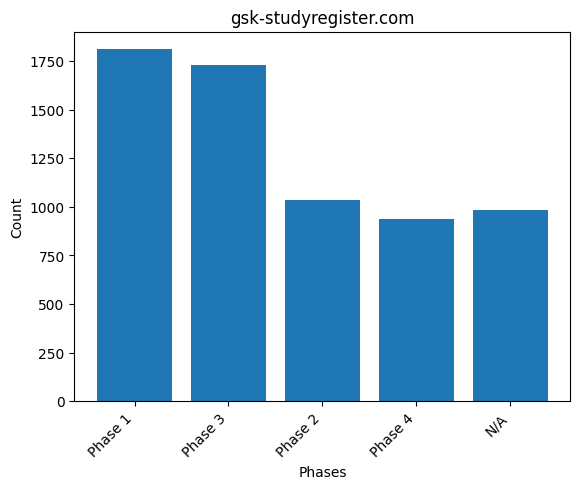

In [93]:
phase_displays = df["PhaseDisplay"].value_counts()
# Remove "N/A" and append it at the end
if "N/A" in phase_displays.index:
    na_count = phase_displays["N/A"]
    phase_displays = phase_displays.drop("N/A")
    phase_displays["N/A"] = na_count

# Get the labels and values
labels = phase_displays.index.tolist()
vals = phase_displays.values.tolist()
# Create a bar graph
plt.bar(labels, vals)

# Add labels and a title
plt.xlabel("Phases")
plt.ylabel("Count")
plt.title("gsk-studyregister.com")
plt.xticks(rotation=45, ha="right")

# Show the graph
plt.show()

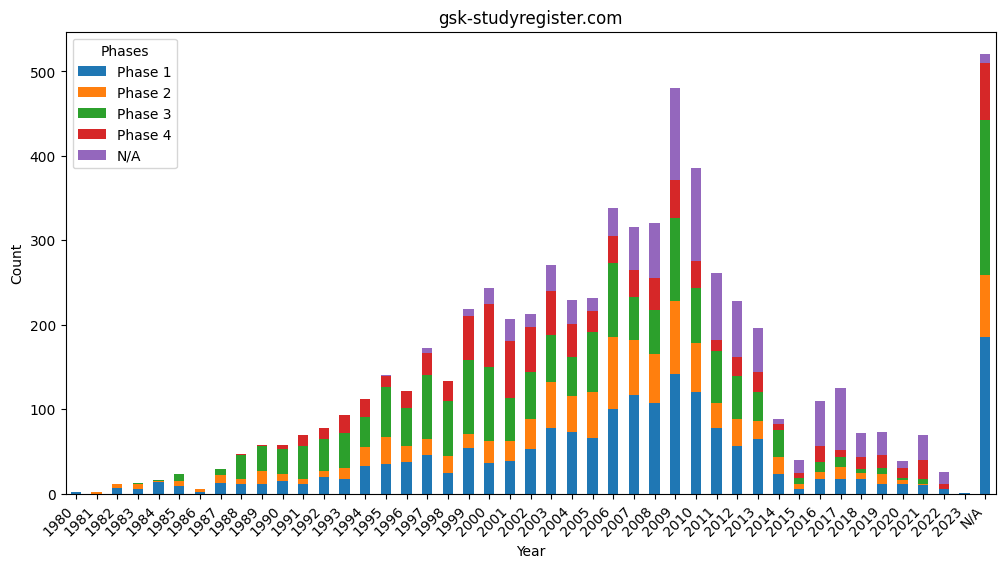

In [100]:
# Convert the start dates to datetime objects
df["StartDate"] = pd.to_datetime(df["StartDate"], errors="coerce")
df["StartYear"] = df["StartDate"].dt.year
# Ensure 'StartYear' is an integer type (after coercing NaT to NaN)
df["StartYear"] = df["StartYear"].fillna(0).astype(int)
# Don't call assign missing date "0", assign "N/A" instead
df["StartYear"] = df["StartYear"].replace(0, "N/A")

phase_counts_by_year = df.groupby(["StartYear", "PhaseDisplay"]).size().unstack(fill_value=0)

# Reorder columns to ensure "N/A" comes last
phase_order = [col for col in phase_counts_by_year.columns if col != "N/A"]
phase_order.append("N/A")
phase_counts_by_year = phase_counts_by_year[phase_order]

# Plot a histogram for each phase
phase_counts_by_year.plot(kind="bar", stacked=True, figsize=(12, 6))

plt.xlabel("Year")
plt.ylabel("Count")
plt.title("gsk-studyregister.com")
plt.xticks(
    ticks=range(len(phase_counts_by_year.index)),
    labels=phase_counts_by_year.index.astype(str),
    rotation=45,
    ha="right",
)
plt.legend(title="Phases")
plt.show()

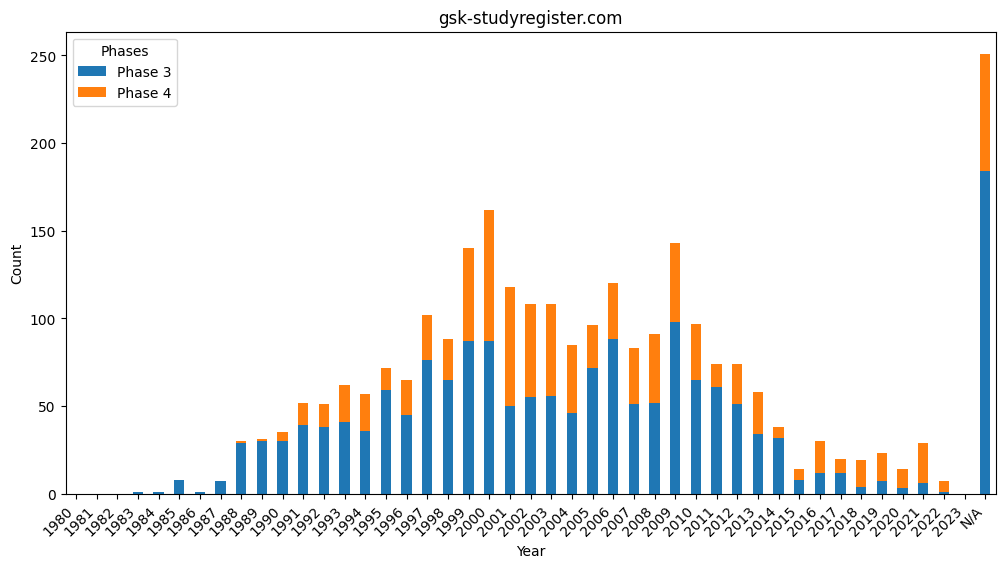

In [102]:
# Group by 'StartYear' and 'PhaseDisplay' and unstack
phase_counts_by_year = df.groupby(["StartYear", "PhaseDisplay"]).size().unstack(fill_value=0)

# Drop unwanted phases
phase_counts_by_year.drop(columns=["N/A", "Phase 1", "Phase 2"], inplace=True, errors="ignore")

# Plot a histogram for each phase
phase_counts_by_year.plot(kind="bar", stacked=True, figsize=(12, 6))

plt.xlabel("Year")
plt.ylabel("Count")
plt.title("gsk-studyregister.com")
plt.xticks(
    ticks=range(len(phase_counts_by_year.index)),
    labels=phase_counts_by_year.index.astype(str),
    rotation=45,
    ha="right",
)
plt.legend(title="Phases")
plt.show()

In [103]:
# WTF happened to Phase 3 trials since 2015?

In [105]:
df["StatusDisplay"].unique()

array(['Study Complete'], dtype=object)